<div>
<img src="figures/svtLogo.png"/>
</div>

<center><h1>Mathematical Optimization for Engineers</h1></center>
<center><h2>Bonus exercise 2</h2></center>

In Lecture 10, you learn about methods for deterministic global optimization of non-linear *non-convex* functions. One of these methods is the Branch-and-Bound method where the feasible set is iteratively branched and pruned, based on a check against estimated upper and lower bounds on the optimal solution. In this exercise, you will implement the bounding procedure and apply it in a branch and bound algorithm for problems of the following class:

\begin{align} \label{eq:optprob}
  \min_{\boldsymbol{x}\in\mathbb{R}^n}\;& \boldsymbol{x}^T\boldsymbol{H}\boldsymbol{x} + \boldsymbol{c}^T\boldsymbol{x}\\
  \mathrm{s.t.}\; & \boldsymbol{x}^T\boldsymbol{Q}_i\boldsymbol{x} + \boldsymbol{a}_i\boldsymbol{x} = b_i\; \forall\; i\in\, \{1,...,m\}\\
  & \boldsymbol{x}^L \leq \boldsymbol{x} \leq \boldsymbol{x}^U
\end{align}

with $n,m\in\mathbb{N}$, $m<n$, a symmetric, positive semidefinite matrix $\boldsymbol{H}\in\mathbb{R}^{n\times n}$, symmetric indefinite matrices $\boldsymbol{Q}_i\in\mathbb{R}^{n\times n}\,\forall i\in \{1,...,m\}$, $\boldsymbol{c}\in\mathbb{R}^n$, $\boldsymbol{A}\in\mathbb{R}^{m\times n}$ with row vectors $\boldsymbol{a}_i$, and $\boldsymbol{b}\in\mathbb{R}^m$.
The above problem is a nonconvex optimization problem with the possibility of suboptimal local minima.

Example 1 fits into this formulation: 
\begin{align}
  \min_{\boldsymbol{x}\in \mathbb{R}^3}\;& x_1 + x_2 + x_3^2\\
  \mathrm{s.t.}\; & x_1x_2 + x_3 = 8\\
  &x_2x_3 = 15 \\
  & 0 \leq x_1, x_2, x_3 \leq 10
\end{align}

The terms $x_1x_2$ and $x_2x_3$, which are responsible for the non-convexity of the model, are called *bilinear* terms.
In example 1, the matrices and vectors in the general problem definition would be
\begin{align}
  \begin{array}{ccc}
  \boldsymbol{c} = \left[1,1,0\right]^T,&\boldsymbol{b} = \left[8,15\right]^T, &\boldsymbol{A} = \left[\begin{array}{ccc}0&0&1\\0&0&0\end{array}\right]\\\boldsymbol{H} = \left[\begin{array}{ccc}0&0&0\\0&0&0\\0&0&1\end{array}\right]\,&
  \boldsymbol{Q}_1 = \left[\begin{array}{ccc}0&0.5&0\\0.5&0&0\\0&0&0\end{array}\right],\,&
  \boldsymbol{Q}_2 = \left[\begin{array}{ccc}0&0&0\\0&0&0.5\\0&0.5&0\end{array}\right]
\end{array}
\end{align}

### The Algorithm
In order to get a lower bound on the objective value of the nonconvex optimization problem, we need to construct a *convex relaxation* and solve it to global optimality.
One widely used relaxation of the *bilinear* terms $x_ix_j$ are the so-called *McCormick Envelopes*.
The relaxation works as follows:
each term $x_ix_j$ is replaced by an auxiliary variable $w_{ij}$.
Then, the following constraints for $w_{ij}$ are defined:

\begin{align}
  w_{ij} &\geq x_i^Lx_j + x_ix_j^L - x_i^Lx_j^L\label{eq:mcccormick1}\\
  w_{ij} &\geq x_i^Ux_j + x_ix_j^U -x_i^Ux_j^U\label{eq:mcccormick2}\\
  w_{ij} &\leq x_i^Ux_j+x_ix_j^L -x_i^Ux_j^L\label{eq:mcccormick3}\\
  w_{ij} &\leq x_i^Lx_j+x_ix_j^U -x_i^Lx_j^U\label{eq:mcccormick4}
\end{align}

These constraints are added to the original optimization problem, and the bilinear terms are replaced with the variables $w_{ij}$.
The resulting convex QP (quadratic objective \& linear constraints) is solved using standard methods, yielding a lower bound on the objective value.


Now, complete the implementation below:

In [4]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import cm

# to construct relaxations for lower-bounding problem
from math import inf, sin, cos, sqrt

# for branching
import copy

### Visualization of relaxation for quadratic problem

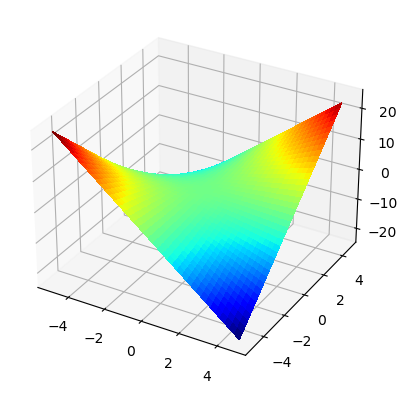

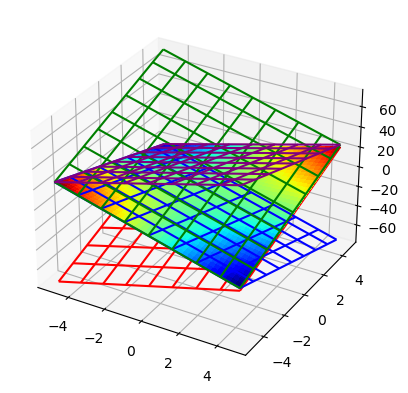

In [5]:
#%matplotlib notebook
# uncomment the first line to have interactive plots

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X_l = -5
X_u = +5
Y_l = -5
Y_u = +5
# Make data.
X = np.arange(X_l, X_u, 0.25)
Y = np.arange(Y_l, Y_u, 0.25)
X, Y = np.meshgrid(X, Y)
Z = (X * Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.jet,
                       linewidth=0, antialiased=False)


# Envelopes
Z1 = (X_l * Y + X * Y_l - X_l * Y_l)
Z2 = (X_u * Y + X * Y_u - X_u * Y_u)
Z3 = (X_u * Y + X * Y_l - X_u * Y_l)
Z4 = (X_l * Y + X * Y_u - X_l * Y_u)

fig1, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax1.plot_surface(X, Y, Z, cmap=cm.jet,
                       linewidth=0, antialiased=False)
surf = ax1.plot_wireframe(X, Y, Z1, rstride=5, cstride=5, color='blue')
surf = ax1.plot_wireframe(X, Y, Z2, rstride=5, cstride=5, color='red')
surf = ax1.plot_wireframe(X, Y, Z3, rstride=5, cstride=5, color='green')
surf = ax1.plot_wireframe(X, Y, Z4, rstride=5, cstride=5, color='purple')


In [6]:
def convex_bounds(n,m,c,H,Q,A,b,lb,ub):
    
    #   n is the number of optimization variables
    #   m is the number of eq constraints
    #   H = positive, semidefinite matrix from objetcive function (n x n)
    #   Q is n x n x m
    #   A is m x n
    #   b is RHS of non linear eq constraints (m x 1)
    #   c,lb,ub are vectors size (n x 1)
    
    def check_symmetric(a, rtol=1e-05, atol=1e-08):
        return np.allclose(a, a.T, rtol=rtol, atol=atol)    
    
    # initialize bounds
    fub = float("inf")
    flb = -float("inf")
    
    # Symmetry test
    #   Check all Qi matrices for symmetry 
    for i in range(m):
        Qi =  Q[:,:,i]
        if (not(check_symmetric(Qi))):
            print("Matrix Q{:d} not symmetric. Check input.".format(i+1))
            return fub, flb

    # Dimension test
    if (np.shape(Q)[0] != n or np.shape(Q)[1] != n or np.shape(Q)[2] != m):
        print("Matrix Q has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(b) != m):
        print("Vector b has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(c) != n):
        print("Vector c has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(lb) != n):
        print("Vector lb has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(ub) != n):
        print("Vector ub has incorrect dimensions. Check input.")
        return fub, flb
    
    if (np.shape(H)[0] != n or np.shape(H)[1] != n):
        print("Matrix H has incorrect dimensions. Check input.")
        return fub, flb 
    
    if (np.shape(A)[0] != m or np.shape(A)[1] != n):
        print("Matrix A has incorrect dimensions. Check input.")
        return fub, flb
    
    # Inspect matices Qi & generate auxilliary variables
    # The Matrix A will be appended with the entries that correspond to 
    # the auxiliary variables wij.
    #   If we do not check for already existing combinations, 
    #   then the same combination x_i.x_j might be treated as
    #   different aux vars in different constraints
    
    # counter variable (count) to know the number of bilinear terms
    count = 0
    combination_exists = 0
    # initialize w_combination to [-1,-1]; stores the already existing combination of bilinear terms
    w_combination = -1*np.ones((1,2))
    # initialize A_help (to be appended later to A)
    A_help = np.zeros((m,1))
    #HINT: Q is of dimension nxnxm (matrix Q_i is called with Q[:,:,i])
    
    # you need to determine which bilinear terms exist and decide wether a combination x_i*x_j already exists
    # Each bilinear term may only be relaxed once.
    # Hint: Is there a difference between x1*x2 and x2*x1?
    # Do we need to consider all entries of Qi?

    # You need to consider all constraints
    # You need to check which bilinear terms are present in each contraint
    # the variables w_combination and A_help will be populated. 
 
    ### YOUR CODE HERE


    # append A_help to A
    if count>0:
        Aeq = np.hstack((A,A_help))
    else:
        Aeq = A
        
    # Create matrix B & b_ineq for inequality constraints
    # where B*x <= b_ineq
    
    ### YOUR CODE HERE

        
    # Initialization of remaining components
    lb_relax = np.append(lb, float('-inf')*np.ones(count))
    ub_relax = np.append(ub, float('inf')*np.ones(count))
    
    
    H_relax = None
    c_relax = None

    # rest of H matrix and C vector must be filled with 0
    if count>0: 
        H_relax = np.hstack((H, np.zeros((n, count))))
        H_relax = np.vstack((H_relax, np.zeros((count, n + count))))
        c_relax = np.hstack((c, np.zeros(count)))
    else:
        H_relax = H
        c_relax = c
            
        
    x0 = np.append((np.array(lb)+np.array(ub))/2, np.zeros(count))
    
    def cvxRelax(x):
        return (np.dot(x.T, np.dot(H_relax, x))+ np.dot(c_relax, x))
    
    def jac(x):
        return (2*np.dot(x.T, H_relax) + c_relax)
    
    ineq_cons  = {'type':'ineq',
        'fun':lambda x: b_ineq - np.dot(B,x),
        'jac':lambda x: -B}
    
    eq_cons  = {'type':'eq',
        'fun':lambda x: b - np.dot(Aeq,x),
        'jac':lambda x: -Aeq}
    
    bounds = optimize.Bounds(lb_relax, ub_relax)
    
    opt = {'disp':True,'maxiter':1000}
    # call optimization for relaxed problem 
    # HINTS:
    # res_lb = ...
    # method='SLSQP', jac=jac,constraints=[eq_cons, ineq_cons], options=opt
    
    ### YOUR CODE HERE
    
    
    # the function value is in res_lb.fun
    return res_lb

In [7]:
def solve_original_problem(n,m,c,H,Q,A,b,lb,ub):
    
    def objective(x):
        return (np.dot(x.T, np.dot(H, x))+ np.dot(c, x))
    
    def eq_cons(x): 
        c = np.zeros(m)
        for i in range(m): 
            c[i] = ### YOUR CODE HERE    
        return c
    
    x0 = (np.array(lb)+np.array(ub))/2
    bounds = optimize.Bounds(lb, ub)
    opt = {'disp':True,'maxiter':1000}
    my_equalities = optimize.NonlinearConstraint(eq_cons, np.zeros(m), np.zeros(m))

    res_ub = optimize.minimize(objective, x0, constraints=[my_equalities],
                            method='SLSQP',bounds=bounds, options=opt)
    # the function value is in res_ub.fun
    return res_ub

### Example 1 (check on bounding procedure)

\begin{align}
  \min_{\boldsymbol{x}\in \mathbb{R}^3}\;& x_1 + x_2 + x_3^2\\
  \mathrm{s.t.}\; & x_1x_2 + x_3 = 8\\
  &x_2x_3 = 15 \\
  & 0 \leq x_1, x_2, x_3 \leq 10
\end{align}


#### Hint 
The value of the valid lower bound is 4.4 and for the upper bound 12.276. 

In [9]:
# problem definition
n = 3
m = 2
c = [1, 1, 0]
b = [8,15]
A = np.zeros((2,3))
A[0,2] = 1

H = np.zeros((3,3))
H[2,2] = 1

Q1 = np.zeros((3,3))
Q1[0,1] = 0.5
Q1[1,0] = 0.5
Q2 = np.zeros((3,3))
Q2[2,1] = 0.5
Q2[1,2] = 0.5
Q = np.dstack((Q1, Q2))

# bounds
lb = [0,0,0]
ub = [10,10,10]

f_lb = convex_bounds(n, m, c, H, Q, A, b, lb, ub)
print("Lower bound is: ", f_lb.fun)
f_ub = solve_original_problem(n, m, c, H, Q, A, b, lb, ub)
print("Upper bound is: ", f_ub.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.400000000000011
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4
Lower bound is:  4.400000000000011
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.276948967035986
            Iterations: 8
            Function evaluations: 32
            Gradient evaluations: 8
Upper bound is:  12.276948967035986


### Example 2 (check on bounding procedure)

\begin{align}
	\min_{\boldsymbol{x}\in \mathbb{R}^4}\;& x_1 + x_2 + x_3^2 + x_{4}^2\\
	\mathrm{s.t. \,}\; & x_1x_2 + x_{2}x_3 = 2\\
	&x_1x_2 + x_{4} = 3 \\
	&x_{1} + x_{2}x_{3} = 5 \\
	& 0 \leq x_1, x_3, x_4 \leq 10 \\
	& 0 \leq x_{2} \leq 4
\end{align}

#### Hint 
The value of the valid lower bound is 6.2 and 6.4 for the upper bound.

In [10]:
# define the optimization problem

### YOUR CODE HERE

f_lb = convex_bounds(n, m, c, H, Q, A, b, lb, ub)
print("Lower bound is: ", f_lb.fun)
f_ub = solve_original_problem(n, m, c, H, Q, A, b, lb, ub)
print("Upper bound is: ", f_ub.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.199999999999999
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Lower bound is:  6.199999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.4
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Upper bound is:  6.4


### Implementation of branch & bound algorithm
Use your implemented function of the lower bounding and upper bounding in a branch & bound algorithm. 
You can either adjust the algorithm of lab 10 or implement it yourself.
However, the required interface must be *branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub)*



In [76]:
# Implementation of branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub) and other required functions.
def branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub): 
    

Hint: The global optimum of example 1 has a function value of 12.276. 

In [81]:
# run example 1

branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.276948967035986
            Iterations: 8
            Function evaluations: 32
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.400000000000011
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4
iter:  1
epsilionF:  7.876948967035975 UBD:  12.276948967035986 LBD:  4.400000000000011
max delta:  10
Lower bounding
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.400000000000017
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 8.55879292396265
            Iterations: 13
            Function evaluations: 29
            Gradient evaluations: 9
Upper bounding
Optimization terminated succes

12.276948967035986

Run global optimization for example 2. 

Hint: The global optimum of example 2 has a function value of 6.4. 

In [82]:
# run example 2

branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.4
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.199999999999999
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
iter:  1
epsilionF:  0.20000000000000107 UBD:  6.4 LBD:  6.199999999999999
max delta:  10
Lower bounding
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.400000000000004
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.400000000000006
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Upper bounding
Optimization terminated successfully    (Exit mode 0)
            Cur

6.4

## The objective function value of the following problem is required for the graded exercise

In [84]:
# Global solution for graded exercise
n = 3
m = 2
c = [1.5, 2, 0] 
b = [2.5, 3.5] 
A = np.zeros((m,n))
A[0,2] = 1.6 
A[1,1] = 1.8
H = np.zeros((n,n))
H[2,2] = 1.1
Q1 = np.zeros((n,n))
Q1[0,1] = 0.5
Q1[1,0] = 0.5
Q1[1,2] = 0.5
Q1[2,1] = 0.5
Q2 = np.zeros((n,n))
Q2[0,1] = 0.5
Q2[1,0] = 0.5
Q = np.dstack((Q1, Q2))
lb = [0, 0, 0]
ub = [12, 4.5, 9]
branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.1271768608602795
            Iterations: 8
            Function evaluations: 32
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9444444444444895
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4
iter:  1
epsilionF:  2.18273241641579 UBD:  4.1271768608602795 LBD:  1.9444444444444895
max delta:  12.0
Lower bounding
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9444444444444393
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 9.991155046827675
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 10
Upper bounding
Optimization terminated 

Iteration limit reached    (Exit mode 9)
            Current function value: 3.723803486927246
            Iterations: 1000
            Function evaluations: 10010
            Gradient evaluations: 998
Upper bounding
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.138161840443907
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
iter:  33
epsilionF:  inf UBD:  4.127176390427192 LBD:  -inf
max delta:  0.5625
Lower bounding
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.124014888468011
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 4.634797260406469
            Iterations: 12
            Function evaluations: 13
            Gradient evaluations: 8
Upper bounding
Optimization terminated successfully    (E

4.127176390427192